In [20]:
import networkx as nx
import random
import matplotlib.pyplot as plt

class SimulacaoIncendio:
    def __init__(self, num_vertices, num_arestas, postos_brigadistas, pontos_agua, capacidade_caminhoes, consumo_por_fogo=1):
        self.grafo = nx.Graph()
        self.consumo_por_fogo = consumo_por_fogo
        self.capacidade_caminhoes = capacidade_caminhoes
        self.brigadistas = {}
        self.postos_brigadistas = set(postos_brigadistas)

        for i in range(num_vertices):
            self.grafo.add_node(i, fogo=False, agua=False, queimado=False, posto_brigadista=(i in self.postos_brigadistas))

        arestas_adicionadas = set()
        while len(arestas_adicionadas) < num_arestas:
            u, v = random.sample(range(num_vertices), 2)
            if (u, v) not in arestas_adicionadas and (v, u) not in arestas_adicionadas:
                peso = random.randint(1, 10)
                self.grafo.add_edge(u, v, weight=peso)
                arestas_adicionadas.add((u, v))

        for p in postos_brigadistas:
            self.brigadistas[p] = (p, self.capacidade_caminhoes)
            self.grafo.nodes[p]['agua'] = True
        for p in pontos_agua:
            self.grafo.nodes[p]['agua'] = True

        self.fogo_ativo = []
        self.fogos_apagados = []  
        self.pos = nx.spring_layout(self.grafo)

    def iniciar_fogo(self, inicio):
        if self.grafo.nodes[inicio]['agua'] or self.grafo.nodes[inicio]['queimado'] or self.grafo.nodes[inicio]['posto_brigadista']:
            return  
        self.fogo_ativo.append(inicio)
        self.grafo.nodes[inicio]['fogo'] = True

    def propagar_fogo(self):
        novos_focos = []
        for v in self.fogo_ativo:
            for vizinho in self.grafo.neighbors(v):
                if not self.grafo.nodes[vizinho]['fogo'] and not self.grafo.nodes[vizinho]['agua'] and not self.grafo.nodes[vizinho]['queimado'] and not self.grafo.nodes[vizinho]['posto_brigadista']:
                    novos_focos.append(vizinho)
                    self.grafo.nodes[vizinho]['fogo'] = True
        self.fogo_ativo.extend(novos_focos)

    def apagar_fogo(self, vertice):
        self.grafo.nodes[vertice]['fogo'] = False
        self.grafo.nodes[vertice]['queimado'] = True
        self.fogo_ativo.remove(vertice)
        self.fogos_apagados.append(vertice)  

    def caminho_mais_curto(self, origem, destino):
        try:
            return nx.shortest_path(self.grafo, origem, destino, weight='weight')
        except nx.NetworkXNoPath:
            return None

    def enviar_brigadistas(self):
        if not self.fogo_ativo:
            return

        for brigadista, (posicao_atual, agua) in self.brigadistas.items():
            if agua < self.consumo_por_fogo:
                ponto_reabastecimento = min(
                    (n for n in self.grafo.nodes if self.grafo.nodes[n]['agua']),
                    key=lambda p: nx.shortest_path_length(self.grafo, posicao_atual, p, weight='weight'),
                    default=None
                )
                if ponto_reabastecimento:
                    print(f"💧 Brigadista {brigadista} sem água indo reabastecer em {ponto_reabastecimento}.")
                    self.brigadistas[brigadista] = (ponto_reabastecimento, self.capacidade_caminhoes)
                continue  

            foco_mais_proximo = min(
                (f for f in self.fogo_ativo if f != posicao_atual),
                key=lambda f: nx.shortest_path_length(self.grafo, posicao_atual, f, weight='weight'),
                default=None
            )

            if foco_mais_proximo:
                caminho = self.caminho_mais_curto(posicao_atual, foco_mais_proximo)
                if caminho:
                    self.brigadistas[brigadista] = self.deslocar_brigadista(brigadista, caminho, agua)

    def deslocar_brigadista(self, brigadista, caminho, agua):
        if not caminho:
            return self.brigadistas[brigadista]
        
        posicao_atual = caminho[0]
        destino = caminho[-1]
        caminho_percorrido = caminho[1:-1]

        print(f"🚒 Brigadista {brigadista} ({agua}L) saindo de {posicao_atual} para apagar fogo em {destino}. Passou por {caminho_percorrido}")

        for v in caminho_percorrido:
            if self.grafo.nodes[v]['agua']:
                print(f"💧 Brigadista {brigadista} reabastecendo em {v}.")
                return (v, self.capacidade_caminhoes)

        if self.grafo.nodes[destino]['fogo']:
            self.apagar_fogo(destino)
            agua -= self.consumo_por_fogo
            print(f"🔥 Fogo apagado em {destino} pelo brigadista {brigadista} (Restante: {agua}L).")
            return (destino, agua)

        return (destino, agua)  

    def simular(self, inicio_fogo):
        self.iniciar_fogo(inicio_fogo)
        
        print("🖼️ Exibindo estado inicial do grafo...")
        self.desenhar_grafo(1)  

        estado = 2
        while self.fogo_ativo:
            self.propagar_fogo()

            # 🔥 Exibe fogos ativos antes da ação dos brigadistas
            print(f"🔥 Fogo ativo nos vértices antes da ação dos brigadistas: {sorted(self.fogo_ativo)}")

            self.enviar_brigadistas()

            # 🔥 Exibe fogos ativos depois da ação dos brigadistas
            print(f"🔥 Fogo ativo nos vértices após a ação dos brigadistas: {sorted(self.fogo_ativo)}")

            self.desenhar_grafo(estado)
            estado += 1

        print(f"✅ Simulação concluída. Fogos apagados: {sorted(self.fogos_apagados)}")

    def desenhar_grafo(self, estado):
        plt.clf()
        node_colors = []
        for n in self.grafo.nodes:
            if self.grafo.nodes[n]['fogo']:
                node_colors.append('red')  
            elif any(self.brigadistas[b][0] == n for b in self.brigadistas):
                node_colors.append('yellow')  
            elif self.grafo.nodes[n]['agua'] or self.grafo.nodes[n]['posto_brigadista']:
                node_colors.append('blue')  
            elif self.grafo.nodes[n]['queimado']:
                node_colors.append('gray')  
            else:
                node_colors.append('green')  

        plt.figure(figsize=(10, 8))
        nx.draw(self.grafo, self.pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10)

        edge_labels = nx.get_edge_attributes(self.grafo, 'weight')
        nx.draw_networkx_edge_labels(self.grafo, self.pos, edge_labels=edge_labels, font_size=9)

        plt.title(f"Estado Atual do Grafo [estado {estado}]")
        plt.draw()
        plt.pause(1.5)




🖼️ Exibindo estado inicial do grafo...


<Figure size 640x480 with 0 Axes>

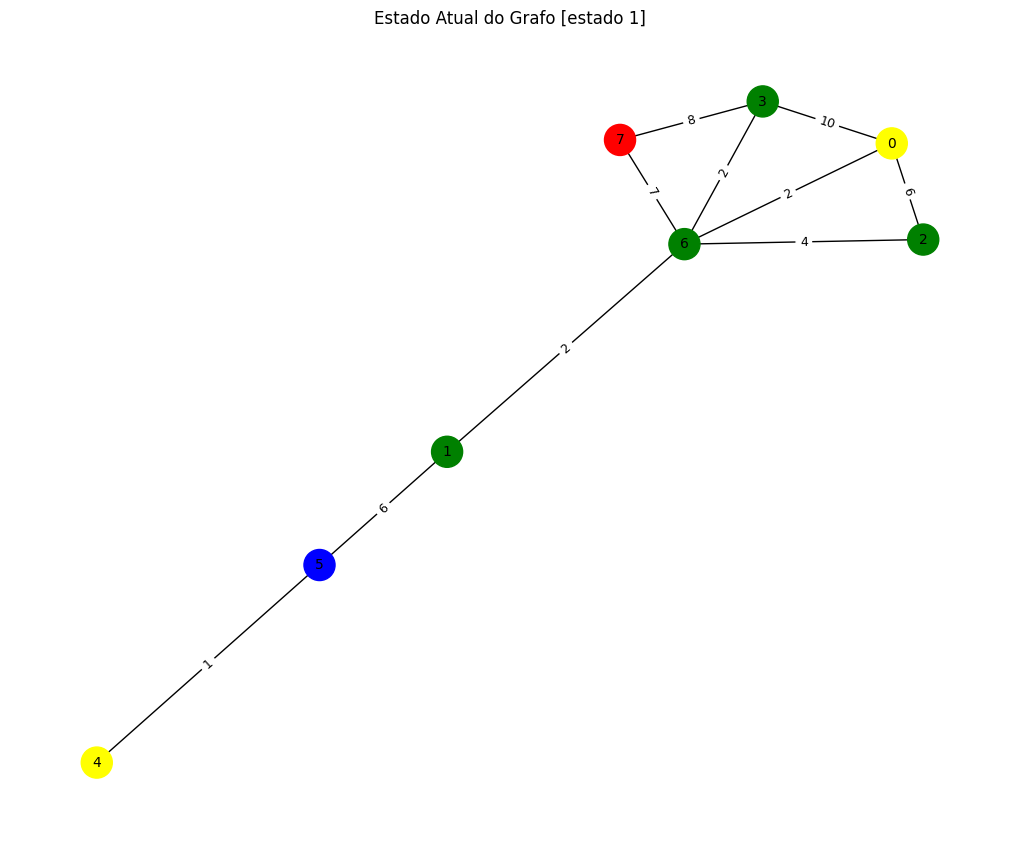

🔥 Fogo ativo nos vértices antes da ação dos brigadistas: [3, 6, 7]
🚒 Brigadista 0 (3L) saindo de 0 para apagar fogo em 6. Passou por []
🔥 Fogo apagado em 6 pelo brigadista 0 (Restante: 2L).
🚒 Brigadista 4 (3L) saindo de 4 para apagar fogo em 3. Passou por [5, 1, 6]
💧 Brigadista 4 reabastecendo em 5.
🔥 Fogo ativo nos vértices após a ação dos brigadistas: [3, 7]


<Figure size 640x480 with 0 Axes>

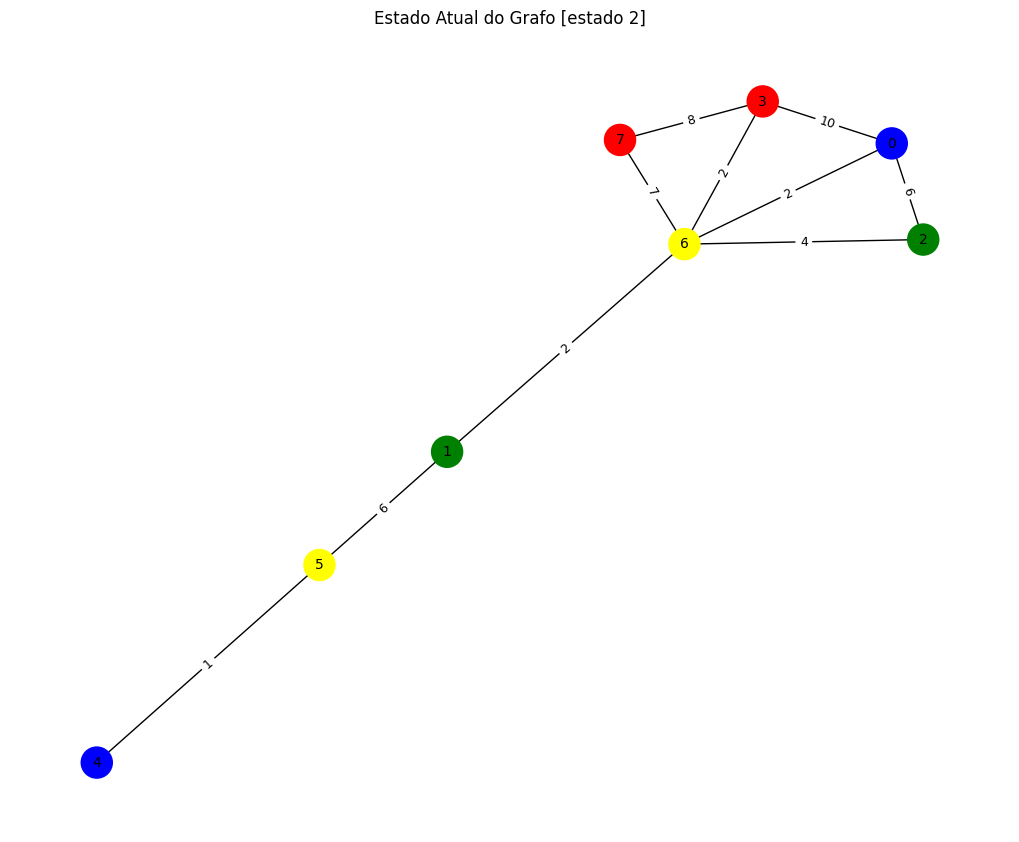

🔥 Fogo ativo nos vértices antes da ação dos brigadistas: [3, 7]
🚒 Brigadista 0 (2L) saindo de 6 para apagar fogo em 3. Passou por []
🔥 Fogo apagado em 3 pelo brigadista 0 (Restante: 1L).
🚒 Brigadista 4 (3L) saindo de 5 para apagar fogo em 7. Passou por [1, 6]
🔥 Fogo apagado em 7 pelo brigadista 4 (Restante: 2L).
🔥 Fogo ativo nos vértices após a ação dos brigadistas: []


<Figure size 640x480 with 0 Axes>

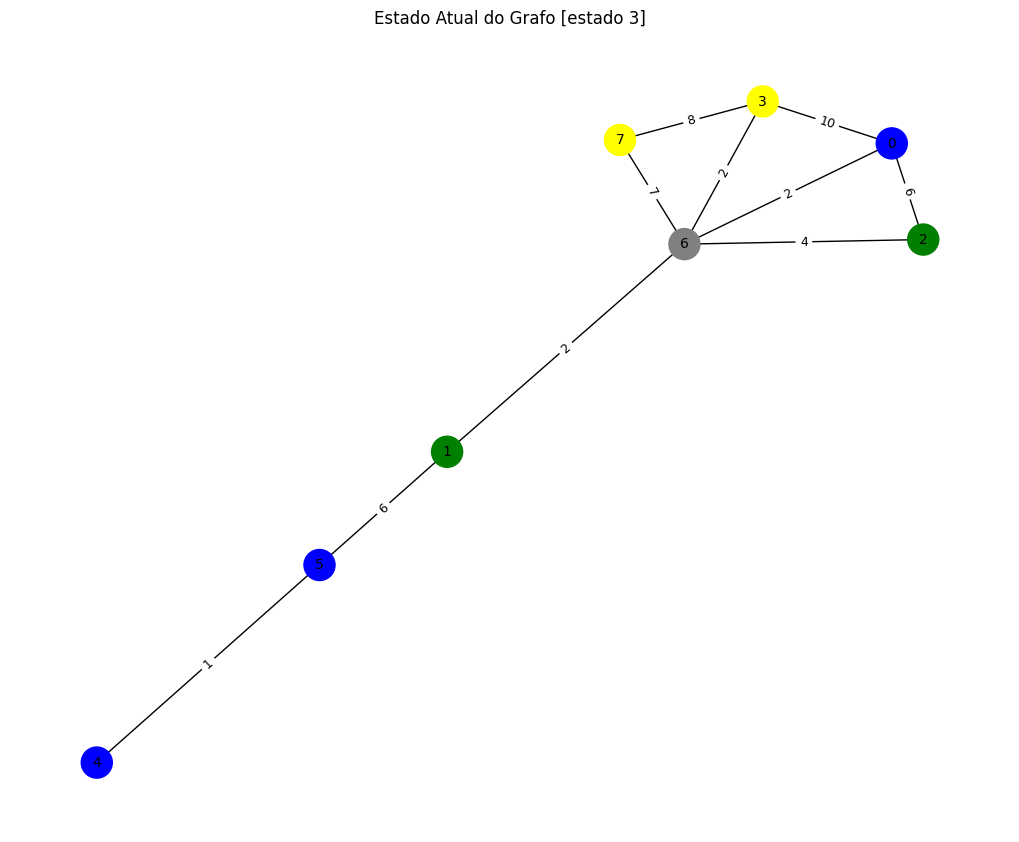

In [ ]:

# Exemplo de uso
sim = SimulacaoIncendio(num_vertices=8, num_arestas=10, postos_brigadistas=[0, 4], pontos_agua=[5], capacidade_caminhoes=3)
sim.simular(inicio_fogo=7)
